In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  
import tensorflow.keras as keras

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.math import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
from google.colab import drive
drive.mount('/content/drive')

np.random.seed(42)

gpu_info = !nvidia-smi -L
gpu_info = '\n'.join(gpu_info)
print(gpu_info)



KeyboardInterrupt: ignored

In [ ]:
#Function to create a model

def create_model(input_shape,
                 n_classes,
                 loss,
                 units_LSTM=[256,128,64],
                 units_Dense=[64,32],
                 dropout_LSTM=0.2,
                 dropout_Dense=0.15,
                 learning_rate=0.001
                 ):
    """
    Creates a LSTM model with 3 LSTM layers and 3 dense layers (the last one is output layer)
    """
    assert units_LSTM[2] == units_Dense[0], "Dimensions of 3rd LSTM Layer and 1st Dense Layer should fit"

    model = keras.Sequential()
    # 2 LSTM layers
    model.add(keras.layers.LSTM(units=units_LSTM[0],
                                input_shape=input_shape,
                                return_sequences=True,
                                dropout=dropout_LSTM
                                ))

    model.add(keras.layers.LSTM(units=units_LSTM[1],
                                input_shape=input_shape,
                                return_sequences=True,
                                dropout=dropout_LSTM
                                ))

    model.add(keras.layers.LSTM(units_LSTM[2]))

    # dense layers
    model.add(keras.layers.Dense(units=units_Dense[0], activation='relu'))
    model.add(keras.layers.Dropout(dropout_Dense))

    model.add(keras.layers.Dense(units_Dense[1], activation='relu'))
    model.add(keras.layers.Dropout(dropout_Dense))

    # output layer
    model.add(keras.layers.Dense(n_classes, activation='softmax'))

    #compile the model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=loss,
                  metrics=['accuracy'])
    
    return model

def get_2d_conv_model(input_shape,
                 n_classes,
                 loss,
                 dropout_Dense=0.15,
                 learning_rate=0.001):
    
    model = keras.Sequential()
    inp = keras.layers.Input(shape=(input_shape[0], input_shape[1], 1))
    model.add(keras.layers.Convolution2D(512, (4,4), padding="same"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.MaxPool2D())
    model.add(keras.layers.Dropout(dropout_Dense))

    
    model.add(keras.layers.Convolution2D(256, (4,10), padding="same"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.MaxPool2D())
    model.add(keras.layers.Dropout(dropout_Dense))

    
    model.add(keras.layers.Convolution2D(256, (4,10), padding="same"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.MaxPool2D())
    model.add(keras.layers.Dropout(dropout_Dense))

    
    model.add(keras.layers.Convolution2D(128, (4,10), padding="same"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.MaxPool2D())
    model.add(keras.layers.Dropout(dropout_Dense))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(512))
    model.add(keras.layers.Dropout(dropout_Dense))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(256))
    model.add(keras.layers.Dropout(dropout_Dense))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))

    model.add(keras.layers.Dense(n_classes, activation='softmax'))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=loss,
                  metrics=['accuracy'])
    
    return model
    

In [ ]:
X_raw=np.load('/content/drive/MyDrive/Pro2/fet.npy')
y_raw=pd.read_csv('/content/drive/MyDrive/Pro2/y_raw_clean.csv')

In [ ]:
noice_egz = ["zero", "one","two", "three",
             "four", "five", "six", "seven",
             "eight", "nine","bed", "bird",
             "cat", "dog", "happy", "house",
             "marvin", "sheila", "tree", "wow"]

y_raw['label'] = np.where(y_raw['label'].isin(noice_egz), "unknown", y_raw['label'])
encoded = pd.read_csv('/content/drive/MyDrive/Pro2/models/label_encodings.csv')

y_all = y_raw.merge(encoded, left_on='label', right_on='name',how="left")['index']

In [ ]:
X_raw = X_raw.reshape((65120, 20, 98, 1))
X_train, X_test, y_train, y_test=train_test_split(X_raw,y_all,stratify=y_all,test_size=0.25, random_state=42)

In [ ]:
input_shape = (X_raw.shape[1], X_raw.shape[2]) # 20,98
n_classes=len(np.unique(y_all)) #12

model = get_2d_conv_model(input_shape=input_shape,
                  loss='sparse_categorical_crossentropy',
                  n_classes=n_classes,
                  dropout_Dense=0.3,
                  learning_rate=0.001)


In [ ]:
callbacks=[
           ReduceLROnPlateau(
               monitor='val_loss',
               factor=0.5,
               patience=3,
               mode='auto',
               cooldown=2,
               min_lr=1e-5),
           EarlyStopping(
               monitor="val_loss",
               min_delta=1e-5,
               patience=15,
               mode="auto",
               restore_best_weights=True),
           ModelCheckpoint('/content/drive/MyDrive/Pro2/models/model_12_classes_conf_matrix.hdf5',
               monitor='val_loss',
               save_best_only=False,
               save_freq='epoch')
]
    
history = model.fit(X_raw, y_all, batch_size=32, callbacks=callbacks,epochs=20)

Epoch 1/20
2035/2035 [==============================] - 155s 76ms/step - loss: 0.8413 - accuracy: 0.7410 - lr: 0.0010
Epoch 2/20
2035/2035 [==============================] - 156s 77ms/step - loss: 0.3600 - accuracy: 0.8851 - lr: 0.0010
Epoch 3/20
2035/2035 [==============================] - 156s 77ms/step - loss: 0.2583 - accuracy: 0.9183 - lr: 0.0010
Epoch 4/20
2035/2035 [==============================] - 157s 77ms/step - loss: 0.2106 - accuracy: 0.9352 - lr: 0.0010
Epoch 5/20
2035/2035 [==============================] - 157s 77ms/step - loss: 0.1764 - accuracy: 0.9461 - lr: 0.0010
Epoch 6/20
2035/2035 [==============================] - 156s 77ms/step - loss: 0.1515 - accuracy: 0.9534 - lr: 0.0010
Epoch 7/20
2035/2035 [==============================] - 155s 76ms/step - loss: 0.1335 - accuracy: 0.9593 - lr: 0.0010
Epoch 8/20
2035/2035 [==============================] - 156s 76ms/step - loss: 0.1187 - accuracy: 0.9644 - lr: 0.0010
Epoch 9/20
1646/2035 [=======================>......] - 

KeyboardInterrupt: ignored

In [ ]:
noice_egz = ["zero", "one","two", "three",
             "four", "five", "six", "seven",
             "eight", "nine","bed", "bird",
             "cat", "dog", "happy", "house",
             "marvin", "sheila", "tree", "wow"]

y_raw['label'] = np.where(y_raw['label'].isin(noice_egz), "unknown", y_raw['label'])
encoded = pd.read_csv('/content/drive/MyDrive/Pro2/models/label_encodings.csv')
y_all = y_raw.merge(encoded, left_on='label', right_on='name')['index']
seen_notseen = np.where(y_all==9, 0, 1)

seen_nseen = ohe.fit_transform(np.array(seen_notseen).reshape(-1 , 1))

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2]) # 20,98
n_classes=len(np.unique(y_train)) #12

model = get_2d_conv_model(input_shape=input_shape,
                  loss='categorical_crossentropy',
                  n_classes=n_classes,
                  dropout_Dense=0.3,
                  learning_rate=0.001)

NameError: ignored

In [ ]:
y_raw

,fname,label
0,0,yes
1,1,yes
2,2,yes
3,3,yes
4,4,yes
...,...,...
65115,65115,silence
65116,65116,silence
65117,65117,silence
65118,65118,silence


In [ ]:
seen_nseen.toarray()

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [ ]:
X_raw = X_raw.reshape((65120, 20, 98, 1))

In [ ]:
# labels_enc=pd.DataFrame(pd.get_dummies(np.array(y_raw['label'])).columns,columns=["name"]).reset_index()
# labels_enc
# labels_enc.to_csv('/content/drive/MyDrive/Pro2/models/label_encodings.csv',index=False)

In [ ]:
X_train, X_test, y_train, y_test=train_test_split(X_raw, seen_nseen.toarray(), test_size=0.20, random_state=42)

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2]) # 20,98
n_classes=len(np.unique(y_train)) #12

model = get_2d_conv_model(input_shape=input_shape,
                  loss='categorical_crossentropy',
                  n_classes=n_classes,
                  dropout_Dense=0.3,
                  learning_rate=0.001)



In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2]) # 20,98
n_classes=len(np.unique(y_train)) #12

model = model=create_model(input_shape=input_shape,
                   n_classes=n_classes,
                   units_LSTM=[512,256,256],
                   units_Dense=[256,128],
                   dropout_LSTM=0.25,
                   dropout_Dense=0.2,
                   learning_rate=0.001,
                   loss="binary_crossentropy")

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 20, 512)           1251328   
                                                                 
 lstm_4 (LSTM)               (None, 20, 256)           787456    
                                                                 
 lstm_5 (LSTM)               (None, 256)               525312    
                                                                 
 dense_9 (Dense)             (None, 256)               65792     
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dropout_5 (Dropout)         (None, 128)              

In [ ]:
callbacks=[
           ReduceLROnPlateau(
               monitor='val_loss',
               factor=0.5,
               patience=3,
               mode='auto',
               cooldown=2,
               min_lr=1e-5),
           EarlyStopping(
               monitor="val_loss",
               min_delta=1e-5,
               patience=10,
               mode="auto",
               restore_best_weights=True),
           ModelCheckpoint('/content/drive/MyDrive/Pro2/models/model_seen_notseen_cNN_2.hdf5',
               monitor='val_loss',
               save_best_only=False,
               save_freq='epoch')
]
    
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, callbacks=callbacks,epochs=1000)

Epoch 1/1000
1628/1628 [==============================] - 214s 131ms/step - loss: 0.4926 - accuracy: 0.7500 - val_loss: 0.2825 - val_accuracy: 0.8884 - lr: 0.0010
Epoch 2/1000
1628/1628 [==============================] - 230s 141ms/step - loss: 0.2544 - accuracy: 0.8959 - val_loss: 0.1999 - val_accuracy: 0.9241 - lr: 0.0010
Epoch 3/1000
1628/1628 [==============================] - 224s 138ms/step - loss: 0.1910 - accuracy: 0.9234 - val_loss: 0.1802 - val_accuracy: 0.9403 - lr: 0.0010
Epoch 4/1000
1628/1628 [==============================] - 231s 142ms/step - loss: 0.1559 - accuracy: 0.9387 - val_loss: 0.1574 - val_accuracy: 0.9504 - lr: 0.0010
Epoch 5/1000
1628/1628 [==============================] - 224s 137ms/step - loss: 0.1334 - accuracy: 0.9467 - val_loss: 0.1177 - val_accuracy: 0.9518 - lr: 0.0010
Epoch 6/1000
1628/1628 [==============================] - 224s 138ms/step - loss: 0.1159 - accuracy: 0.9542 - val_loss: 0.1059 - val_accuracy: 0.9572 - lr: 0.0010
Epoch 7/1000
1628/1628

KeyboardInterrupt: ignored

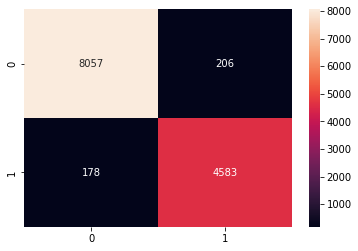

In [ ]:
ar = [ar.argmax() for ar in y_test]
y_pred=model.predict(X_test).argmax(axis=1)
conf_matrix=confusion_matrix(labels=ar,predictions=y_pred)
plt.plot(figsize=(20,18))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.show()
#balanced_accuracy_score(y_test, y_pred)

In [ ]:
noice_egz = ["zero", "one","two", "three",
             "four", "five", "six", "seven",
             "eight", "nine","bed", "bird",
             "cat", "dog", "happy", "house",
             "marvin", "sheila", "tree", "wow"]

y_raw['label'] = np.where(y_raw['label'].isin(noice_egz), "unknown", y_raw['label'])
y_raw = y_raw[y_raw['label'] != "unknown"]
encoded = pd.read_csv('/content/drive/MyDrive/Pro2/models/label_encodings.csv')

y_all = y_raw.merge(encoded, left_on='label', right_on='name')['index']
X_raw = X_raw[y_raw['fname']]
y_all = ohe.fit_transform(np.array(y_all).reshape(-1 , 1))

In [ ]:
X_raw.shape

(24081, 20, 98)

In [ ]:
X_raw = X_raw.reshape((24081, 20, 98, 1))

In [ ]:
X_train, X_test, y_train, y_test=train_test_split(X_raw, y_all.toarray(), test_size=0.20, random=42)

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2]) 
n_classes=11

model = get_2d_conv_model(input_shape=input_shape,
                   n_classes=n_classes,
                   loss="categorical_crossentropy",
                   dropout_Dense=0.3)

In [ ]:
callbacks=[
           ReduceLROnPlateau(
               monitor='val_loss',
               factor=0.5,
               patience=3,
               mode='auto',
               cooldown=2,
               min_lr=1e-5),
           EarlyStopping(
               monitor="val_loss",
               min_delta=1e-5,
               patience=10,
               mode="auto",
               restore_best_weights=True),
           ModelCheckpoint('/content/drive/MyDrive/Pro2/models/model_11_classes_LSTM.hdf5',
               monitor='val_loss',
               save_best_only=False,
               save_freq='epoch')
]
    
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, callbacks=callbacks, epochs=1000)

Epoch 1/1000
602/602 [==============================] - 84s 136ms/step - loss: 1.6639 - accuracy: 0.4013 - val_loss: 0.7155 - val_accuracy: 0.7411 - lr: 0.0010
Epoch 2/1000
602/602 [==============================] - 84s 139ms/step - loss: 0.5924 - accuracy: 0.8016 - val_loss: 0.5386 - val_accuracy: 0.8248 - lr: 0.0010
Epoch 3/1000
602/602 [==============================] - 83s 138ms/step - loss: 0.4247 - accuracy: 0.8618 - val_loss: 0.5978 - val_accuracy: 0.7959 - lr: 0.0010
Epoch 4/1000
602/602 [==============================] - 84s 139ms/step - loss: 0.3343 - accuracy: 0.8915 - val_loss: 0.3203 - val_accuracy: 0.8941 - lr: 0.0010
Epoch 5/1000
602/602 [==============================] - 84s 139ms/step - loss: 0.2819 - accuracy: 0.9069 - val_loss: 0.2864 - val_accuracy: 0.9141 - lr: 0.0010
Epoch 6/1000
602/602 [==============================] - 84s 140ms/step - loss: 0.2464 - accuracy: 0.9183 - val_loss: 0.2636 - val_accuracy: 0.9159 - lr: 0.0010
Epoch 7/1000
602/602 [==================